# 프로젝트: 퍼스널 컬러 진단 - VGG16

## 목차
1. VGG16 아키텍처 체험(학습X, 예측O(class만 ImageNet을 빌려옴))  
참고 링크: https://han-py.tistory.com/213  
2. VGG16 아키텍처에 퍼스널컬러(웜/쿨) 적용하기 (학습O, 예측O)  
참고 링크:https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=dnjswns2280&logNo=221738517884 
3. ImageNet으로 사전 학습된 VGG16에 fine tuning해서 퍼스널컬러(웜/쿨) 적용하기(학습O, 예측O)  
참고 링크: 추후 추가
4. VGGFace2 데이터셋으로 사전 학습된 VGG16 fine tuning해서 퍼스널컬러(웜/쿨) 적용하기  
참고 링크: 추후 추가

In [ ]:
!pip install gdown

In [ ]:
!gdown https://drive.google.com/uc?id=1kdmLChi8dmZQdFaCgoTgALokONW_fvdb -O /aiffel/aiffel/project/first-repository/data/four_seasons

In [ ]:
!pip install --upgrade --no-cache-dir gdown

# 1. VGG16 아키텍처 체험

추가 설명:
이 파트의 핵심 부분은  
model = vgg16.VGG16()  
yhat = model.predict(image)  
label = vgg16.decode_predictions(yhat)  
이 세 코드이다. 이미지를 넣으면 이미 학습된 model에 대해 예측값만 가져오는 것이다.  

1. vgg16.VGG16() 코드는 ImageNet으로 사전 학습된 VGG16 모델을 불러오는 것이다. 이 모델은 이미 이미지넷 데이터셋으로 사전에 학습되어 다양한 객체 및 동물의 이미지를 인식하는 능력을 갖추고 있다.  

2. model.predict(image) 코드는 불러온 VGG16 모델을 사용하여 입력 이미지에 대한 예측을 수행하는 것이다. 이때 image는 모델에 입력으로 주어질 이미지 데이터를 의미한다. 모델은 주어진 이미지에 대해 예측 확률을 반환한다.  

3. vgg16.decode_predictions(yhat) 코드는 VGG16 모델의 예측 결과를 해석하는 함수다. yhat은 model.predict()를 통해 얻은 예측 확률 배열이다. 이 확률 배열을 vgg16.decode_predictions 함수를 사용하여 인간이 이해하기 쉬운 형태로 변환한다.  

따라서 위 코드는 이미 사전 학습된 VGG16 모델을 불러와서 새로운 이미지에 대한 예측을 수행하고, 예측 결과를 해석하여 가장 확률이 높은 상위 K개의 클래스를 확인하는 데 사용된다. 실제로 모델을 새로 학습하지 않더라도 사전 학습된 모델을 활용하여 이미지를 분류할 수 있다. 이렇게 사전 학습된 모델을 이용하는 것을 Transfer Learning이라고 한다.

In [84]:
import tensorflow as tf
import numpy as np
import cv2
import os
import glob
from PIL import Image

In [85]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array # 오류 발생시 tensorflow 재설치하고 런타임 재연결 추천
from tensorflow.keras.applications import vgg16
from IPython.display import display # 이미지 출력 함수

In [86]:
# VGG16 모델 불러오기
model = vgg16.VGG16(include_top=False, weights='imagenet')

# 모델의 모양을 보여준다.
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [87]:
# VGG16 모델 불러오기
model = vgg16.VGG16()

# 모델의 모양을 보여준다.
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [88]:
def predict_vgg16(model, filename) :

    # 이미지 파일을 읽고 화면에 표시
    image = load_img(filename)
    # image = PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=688x550
    display(image)


    # 모델 사이즈로 이미지 파일을 읽기
    image = load_img(filename, target_size=(224, 224))
    # image = PIL.Image.Image image mode=RGB size=224x224


    # 이미지 데이터를 numpy로 변환
    image = img_to_array(image)
    # image.shape = (224, 224, 3)

    # vgg16.preprocess_input()을 호출하기 위해 차원을 조정
    # 보통 모델을 여러 이미지를 한번에 호출.
    # 맨 앞의 1 : 이미지 갯수가 1개라는 것.
    # 두번째 224 : 가로
    # 세번째 224 : 세로
    # 네번째 3 : R, G, B 3개
    image = image.reshape((1, 224, 224, 3))

    # VGG16 모델 호출을 위해 데이터 전처리.
    # -255 ~ 255 사이 값으로 정규화한다.
    # 그리고 RGB를 BGR순으로 바꾼다.
    image = vgg16.preprocess_input(image)


    # 이미지를 모델에 적용
    yhat = model.predict(image)
    # yhat = [[2.03485320e-06 4.21382174e-06 1.45730738e-07 1.04057870e-06
    #          6.61934010e-08 2.63145339e-04 4.49358195e-05 2.03222541e-08
    #          ... ]] # 1000개 클래스에 대한 결과값.
    #


    # 모델 적용된 결과를 파싱
    label = vgg16.decode_predictions(yhat)
    # label = [[('n02655020', 'puffer', 0.9612253), ... ]]

    # 가장 확률이 높은 결과를 획득
    label = label[0][0]
    # label = ('n02655020', 'puffer', 0.9612253)

    # 라벨과 라벨을 예측한 확률을 출력
    print('%s (%.2f%%)' % (label[1], label[2]*100))

In [89]:
# from google.colab import drive
# drive.mount('/content/drive')

In [90]:
# 사진 개별 경로
files = [
    "/aiffel/aiffel/project/first-repository/data/four_seasons/TEST/박은빈.jpg"
]

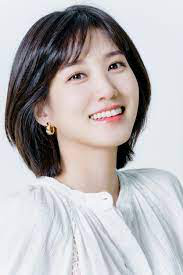

wig (14.63%)


In [91]:
# 각 사진마다 예측된 라벨과 예측한 확률 확인하기
for file in files :
    predict_vgg16(model, file)

# 2. VGG16에 아키텍처에 퍼스널컬러(웜/쿨) 적용하기
- 제대로 학습되는 것이 아님 좀 더 수정이 필요함

## (1) 라이브러리 및 데이터 불러오기

In [135]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import vgg16

import numpy as np
import cv2
import os
import glob
from PIL import Image

In [136]:
#from google.colab import drive
#drive.mount('/content/drive')

In [137]:
# 파일 불러오는 함수
def load_images_from_directory(directory_path):
    image_paths = glob.glob(directory_path + '/*.jpg')  # 디렉토리 내의 모든 jpg 파일 경로 찾기
    image_paths.extend(glob.glob(directory_path + '/*.jpeg'))  # 디렉토리 내의 모든 jpeg 파일 경로 추가

    images = []
    for image_path in image_paths:
        image = Image.open(image_path)
        image_np = np.array(image)
        images.append(image_np)

    return images

In [138]:
# 모든 이미지 불러오기
directory_path = "/aiffel/aiffel/project/first-repository/data/four_seasons/warm_tone"  # 디렉토리 경로
directory_path2 = "/aiffel/aiffel/project/first-repository/data/four_seasons/cool_tone"  # 디렉토리 경로
images = load_images_from_directory(directory_path)
images2 = load_images_from_directory(directory_path2)

length = len(images)
print(length)
print(len(images2))

# 이미지 리스트 합치기
images = np.concatenate((images, images2), axis=0)
print(len(images))

50
50
100


## (2) 데이터 전처리

In [139]:
def preprocess_image(image):
    # 이미지 크기 조절
    image = tf.image.resize(image, (224, 224))
    # 이미지를 [0, 1] 범위로 정규화
    image = image / 255.0
    return image

images = np.array([preprocess_image(image) for image in images])
print(images.shape)

(100, 224, 224, 3)


In [140]:
# labels에 대한 코드
num = len(images)
labels = np.zeros(num)

# 뒤쪽의 50개의 요소를 1로 변경
labels[length:] = 1

# 0이 웜톤 1이 쿨톤
print(len(images))
print(labels.shape)
print(labels)

100
(100,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


## (3) train, val 분리하기

In [141]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(images,
                                                  labels,
                                                  test_size=0.3,
                                                  random_state=33)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (70, 224, 224, 3)
y_train:  (70,)
x_val:  (30, 224, 224, 3)
y_val:  (30,)


In [142]:
# 데이터를 텐서로 변환
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_val = tf.convert_to_tensor(x_val, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.int32)

## (4) 모델 정의 및 컴파일

In [143]:
# VGG16 모델 불러오기
vgg16_model = vgg16.VGG16() # weights='imagenet', include_top=False, input_shape=(224, 224, 3)

# 추가하기
model = models.Sequential()
model.add(vgg16_model)
model.add(layers.Dense(564, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

In [144]:
# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', #categorical_crossentropy , sparse_categorical_crossentropy
              metrics=['accuracy'])

In [145]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1000)              138357544 
_________________________________________________________________
dense_34 (Dense)             (None, 564)               564564    
_________________________________________________________________
dense_35 (Dense)             (None, 32)                18080     
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 66        
Total params: 138,940,254
Trainable params: 138,940,254
Non-trainable params: 0
_________________________________________________________________


## (5) 모델 학습하기

In [151]:
# epochs = 2일때 7분걸림 -> LMS 1분...도 안걸림 ㄷㄷ
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=3,
                    validation_data=(x_val, y_val))

Epoch 1/3
3/3 [==============================] - 1s 331ms/step - loss: 0.6875 - accuracy: 0.5571 - val_loss: 0.7460 - val_accuracy: 0.3667
Epoch 2/3
3/3 [==============================] - 1s 321ms/step - loss: 0.6870 - accuracy: 0.5571 - val_loss: 0.7369 - val_accuracy: 0.3667
Epoch 3/3
3/3 [==============================] - 1s 323ms/step - loss: 0.6866 - accuracy: 0.5571 - val_loss: 0.7271 - val_accuracy: 0.3667


## (6) 예측하기

In [152]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
y_val = np.array(y_val)

In [153]:
print(pred)

[[0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]
 [0.5529555 0.4470445]]


In [154]:
print(pred_class)
print(y_val)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 0 0 0 1 1]


In [155]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.366667


## (7) TEST

In [156]:
class_name = ["웜톤", "쿨톤"]

In [157]:
# test 불러오기 (낱개 버전)
test_path = "/aiffel/aiffel/project/first-repository/data/four_seasons/TEST/손예진.jpg"
x_test = Image.open(test_path)
x_test = np.array(x_test)
print(x_test.shape)

# 배열의 크기 변환
x_test = x_test.reshape((1, x_test.shape[0], x_test.shape[1], 3))
print("변환된 배열 크기:", x_test.shape)

# 전처리(resize, 정규화)
x_test = preprocess_image(x_test)
print(x_test.shape)

# 만약 앱구현과 연결된다면 저장된 모델을 다시 돌릴 필요없이 저장된 최적의 모델을 사용하도록 수정해야함
# test
pred = model.predict(x_test)
pred_class = np.argmax(pred, axis=1)
print("당신은", class_name[int(pred_class)], "입니다~!")
print("웜톤일 확률: ", np.round(pred[:, 0], 3))
print("쿨톤일 확률: ", np.round(pred[:, 1], 3))

(246, 204, 3)
변환된 배열 크기: (1, 246, 204, 3)
(1, 224, 224, 3)
당신은 웜톤 입니다~!
웜톤일 확률:  [0.553]
쿨톤일 확률:  [0.447]


In [159]:
# 쿨톤 기준 확률 적기
# 537
# 545
# 543
# 519 봄웜 박은빈 가을웜 강혜원
# 501
# 0.48 드디러 웜톤을 맞췄다. 근데 왜 값이 완전이 일치하지...? 이번엔 전부 0으로 나왔구나...
# 0.447

# 3. ImageNet으로 사전 학습된 VGG16에 fine tuning해서 퍼스널컬러(웜/쿨) 적용하기

- 아직 더 조사하고 시도해보아야함 하지만 시도해볼 가치가 있을지 모르겠음 왜냐면 ImageNet은 얼굴뿐만 아니라 동물들 물건들 자동차 등등 여러 데이터에 대해 학습한 것이기 때문에 오히려 간단하게 만든 CNN이 더 결과가 잘 나오는 것 같음

# 4. VGGFace2 데이터셋으로 사전 학습된 VGG16 fine tuning해서 퍼스널컬러(웜/쿨) 적용하기

- 

In [163]:
!pip install keras_vggface

In [164]:
from keras_vggface.vggface import VGGFace

# VGGFace2 데이터셋으로 사전 학습된 VGGFace 모델 불러오기
model = VGGFace(model='vgg16', weights='vggface2')

# 모델 구조 및 가중치 확인
model.summary()

ModuleNotFoundError: No module named 'keras.engine.topology'